In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Activation, Layer
# from tensorflow.keras.mixed_precision import experimental as mixed_precision
import pandas as pd
from sklearn import preprocessing
import numpy as np
import io
import os
import random
from datetime import datetime

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

<h2>Use GPU</h2>

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
              tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
        
print(tf.config.experimental.list_logical_devices('GPU'))
tf.test.is_gpu_available()

# set up policy used in mixed precision
# policy = mixed_precision.Policy('mixed_float16')
# mixed_precision.set_policy(policy)

1 Physical GPUs, 1 Logical GPUs
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

<h2>Create Environments</h2>

In [3]:
# read data
prices = pd.read_csv('../../data/854_1575_bundle_archive/prices-split-adjusted.csv')
fundamentals = pd.read_csv('../../data/854_1575_bundle_archive/fundamentals.csv')

# fix fundamentals and prices
fundamentals = pd.read_csv('../../data/854_1575_bundle_archive/fundamentals.csv')
fundamentals = fundamentals.drop(columns=fundamentals.columns[0]).dropna()
fundamentals["Key"] = fundamentals["Ticker Symbol"]+fundamentals["For Year"].astype(int).astype(str)
fundamentals = fundamentals.drop(columns="Ticker Symbol")
fundamentals = fundamentals.drop(columns="Period Ending")
fundamentals = fundamentals.drop(columns="For Year")

prices["year"] = prices.date.str[:4]
prices["Key"] = prices.symbol+prices.year

# join price/fundamentals
data = prices.merge(fundamentals, on='Key')
data = data.drop(["date","year","Key"], axis=1)

class Stocks_env:

    def __init__(self, data, batch_size, window_size, run_lenght, 
                 boundary = 0.5, trader_happiness=0.2, daily_investment=1):
        self.data = data
        self.batch_size = batch_size
        self.run_lenght = run_lenght
        self.window_size = window_size
        self.batch_data = []
        self.state_index = 0
        self.money = 0
        self.previous_money = 0
        self.boundary = boundary
        self.owned = np.zeros(self.batch_size)
        self.trader_happiness = trader_happiness
        self.daily_investment = daily_investment
        self.current_symbols = None
        self.current_ending_day = []

        # fit normalizer
        fit_data = self.data.drop(["symbol"], axis=1)
        self.scaler = preprocessing.StandardScaler().fit(fit_data)

        unique_symbols = pd.unique(data.symbol)
        self.test_symbols = np.random.choice(unique_symbols, int(len(unique_symbols)*0.2), replace=False)
        self.train_symbols = np.setdiff1d(unique_symbols, self.test_symbols)

    def get_observation_space(self):
        return (self.window_size, 80)

    def get_action_space(self):
        return (1)

    def get_scaler(self):
        return self.scaler

    def get_current_symbols(self):
        return self.current_symbols

    def get_test_symbols(self):
        return self.test_symbols

    def reset(self, trader_happiness=None, daily_investment=None, training=True, batch_size=None):
        self.state_index = 0
        self.money = 0
        self.previous_money = 0
        if batch_size:
            self.batch_size = batch_size
        if trader_happiness:
            self.trader_happiness = trader_happiness
        if daily_investment:
            self.daily_investment = daily_investment
        self.owned = np.zeros(self.batch_size)
        self.current_ending_day = []
        self.batch_data = []
        if training:
            sampled_symbols = np.random.choice(self.train_symbols, self.batch_size, replace=False)
        else:
            self.trader_happiness = 0
            sampled_symbols = np.random.choice(self.test_symbols, self.batch_size, replace=False)            
        self.current_symbols = sampled_symbols
        self.current_end_index = []
        for symbol in sampled_symbols:
            end_index = random.randint(self.window_size+self.run_lenght+1, len(data[data.symbol==symbol]))
            self.current_ending_day.append(end_index) 
            selected_data = data[data.symbol==symbol][end_index-(self.window_size+self.run_lenght+1):end_index]
            selected_data = selected_data.drop(["symbol"], axis=1)
            self.batch_data.append(selected_data.astype('float32'))

        state = list(map(lambda x: self.scaler.transform(x[0:self.window_size]), self.batch_data))
        return np.array(state)

    def step(self, action):
        current_day = self.state_index+self.window_size

        # get next state
        next_state = list(map(lambda x: self.scaler.transform(x[self.state_index:current_day]), self.batch_data))

        operations = np.zeros(self.batch_size)

        # buy/sell following short or long strategies
        stocks_price = 0
        total_investment = 0
        for i in range(self.batch_size):
            investment = (abs(np.clip(np.array(action[i]),-1.5,1.5))-0.5)*self.daily_investment
            traded = investment/float(self.batch_data[i].iloc[[current_day+1]].close)
            if action[i]>self.boundary:
                # positive buy/sell policy -> buy
                total_investment += investment
                self.owned[i] += traded
                operations[i] = investment
                self.money = self.money - investment
            elif action[i]<-self.boundary:
                # negative buy/sell policy -> sell
                # make traded positive for later usage on the reward calculation
                total_investment += investment
                self.owned[i] -= traded
                operations[i] = -investment
                self.money = self.money + investment
            stocks_price += self.owned[i]*float(self.batch_data[i].iloc[[current_day+1]].close)

        # calculate profit (reward)            
        owned_price = stocks_price + self.money
        profit = owned_price-self.previous_money
        self.previous_money = owned_price
        reward = profit*(1-self.trader_happiness)+total_investment*self.trader_happiness

        self.state_index += 1

        # finished the run?
        if self.state_index >= self.run_lenght:
            done = True
        else:
            done = False

        return np.array(next_state), reward, done, operations, np.array(self.current_ending_day)+self.state_index-self.run_lenght+1

<h2>Neural Network</h2>

In [4]:
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead) 
    but it must be broadcastable for addition.

    Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
    output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights


class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, 
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights

class SharedBlock(Layer):

    def __init__(self, hidden_dim=1024, num_filters=128, lstm_units=10,
                 name="shared block", rate=0.1, **kwargs):
        super(SharedBlock, self).__init__(name=name, **kwargs)
        self.dense_layer = tf.keras.layers.Dense(hidden_dim)
        self.cnn_layer1 = tf.keras.layers.Conv1D(
            filters=num_filters,
            kernel_size=4,
            # Use 'same' padding so outputs have the same shape as inputs.
            padding='same')
        self.cnn_layer2 = tf.keras.layers.Conv1D(
            filters=int(num_filters/2),
            kernel_size=4,
            # Use 'same' padding so outputs have the same shape as inputs.
            padding='same')
        self.bn_layer1 = tf.keras.layers.BatchNormalization()
        self.bn_layer2 = tf.keras.layers.BatchNormalization()
        self.activation_layer = Activation('relu')
        self.attention_layer1 = MultiHeadAttention(d_model=hidden_dim, num_heads=8)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.attention_layer2 = MultiHeadAttention(d_model=hidden_dim, num_heads=8)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.lstm_layer = tf.keras.layers.LSTM(lstm_units)

    def call(self, x, training, mask=None):
        x_ = self.dense_layer(x)

        # x = self.cnn_layer1(x_)
        # x = self.bn_layer1(x)
        # x = self.activation_layer(x)

        # attn_output, _ = self.attention_layer1(x, x, x, mask)
        # attn_output = self.dropout1(attn_output, training=training)
        # x_ = self.layernorm1(x_ + attn_output)
        
        x = self.cnn_layer2(x_)
        x = self.bn_layer2(x)
        x = self.activation_layer(x)

        attn_output, _ = self.attention_layer2(x,x,x,mask)
        attn_output = self.dropout2(attn_output, training=training)
        x = self.layernorm2(x_ + attn_output)
        
        return self.lstm_layer(x)

    
class Critic(Layer):

    def __init__(self, num_policies, hidden_dim=1024, num_filters=128, lstm_units=10, 
                 name="critic", **kwargs):
        super(Critic, self).__init__(name=name, **kwargs)
        self.shared_block = SharedBlock(hidden_dim=hidden_dim, num_filters=num_filters, lstm_units=lstm_units)
        self.dense_layer = tf.keras.layers.Dense(num_policies, name='critic_output')
        
    def call(self, x):
        x = self.shared_block(x)
        
        return self.dense_layer(x)

class Actor(Layer):

    def __init__(self, hidden_dim=1024, num_filters=128, lstm_units=10, 
                 name="actor", **kwargs):
        super(Actor, self).__init__(name=name, **kwargs)
        self.shared_block = SharedBlock(hidden_dim=hidden_dim, num_filters=num_filters, lstm_units=lstm_units)
        self.dense_layer = tf.keras.layers.Dense(1, name='actor_output')
        
    def call(self, x):
        x = self.shared_block(x)

        return self.dense_layer(x)
    
class ActorCritic(Model):

    def __init__(self, num_policies, hidden_dim=1024, num_filters=128, lstm_units=10):
        super(ActorCritic, self).__init__()
        self.critic = Critic(num_policies = num_policies, hidden_dim=hidden_dim, 
                             num_filters=num_filters, lstm_units=lstm_units)
        self.actor = Actor(hidden_dim=hidden_dim, num_filters=num_filters, lstm_units=lstm_units)
        self.logstd = tf.Variable(np.zeros([1, num_policies]),  dtype=tf.float32 ,name='logstd')

    def call(self, x):
        # Actor
        value = self.actor(x)

        # Critic
        critic_output = self.critic(x)
        std = tf.zeros_like(critic_output) + tf.exp(self.logstd)
        dist = tfp.distributions.Normal(loc=critic_output, scale=std)

        return value, dist    

<h2>GAE and PPO</h2>

In [5]:
def compute_gae(next_value, rewards, masks, values, gamma=0.99, tau=0.95):
    values = values + [next_value]
    gae = 0
    returns = []
    for step in reversed(range(len(rewards))):
        delta = rewards[step] + gamma * values[step + 1] * masks[step] - values[step]
        gae = delta + gamma * tau * masks[step] * gae
        returns.insert(0, gae + values[step])
    return returns

In [6]:
def ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantage):
    batch_size = tf.shape(states)[0]
    for _ in range(batch_size // mini_batch_size):
        rand_ids = np.random.randint(0, batch_size, mini_batch_size)
        yield states.numpy()[rand_ids, :], actions.numpy()[rand_ids, :], log_probs.numpy()[rand_ids, :], returns.numpy()[rand_ids, :], advantage.numpy()[rand_ids, :]

def ppo_update(ppo_epochs, mini_batch_size, states, actions, log_probs, returns, advantages, clip_param=0.2):
    for _ in range(ppo_epochs):
        for state, action, old_log_probs, return_, advantage in ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantages):
            with tf.GradientTape() as tape:
                # value, dist = model(state, np.reshape(state[:,-1,:],(batch_size, 1, num_inputs[1])))
                value, dist = model(state)
                        
                entropy = tf.math.reduce_mean(dist.entropy())
                new_log_probs = dist.log_prob(action)

                ratio = tf.math.exp(new_log_probs - old_log_probs)
                surr1 = ratio * advantage
                surr2 = tf.clip_by_value(ratio, clip_value_min=1.0 - clip_param, 
                                         clip_value_max=1.0 + clip_param) * advantage

                actor_loss  = - tf.math.reduce_mean(tf.math.minimum(surr1, surr2))
                critic_loss = tf.math.reduce_mean(tf.math.pow(return_ - value, 2))

                loss = 0.5 * critic_loss + actor_loss - 0.001 * entropy
                
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

<h2>Train</h2>

In [7]:
batch_size = 3
window_size = 32
run_lenght = 32

# Hyper params:
lr               = 3e-4
run_lenght       = 32
batch_size       = 128
window_size      = 32
ppo_epochs       = 4
num_epochs       = 3000
test_iterations  = 1
threshold_reward = 400
happiness_alpha  = 0.9
happiness_beta   = 0.03
hidden_dim       = 1024
num_filters      = 128
lstm_units       = 1024

# log
log_freq = 1
models_directory = 'results/models/'
save_directory = 'results/saved-timesteps/'
date = datetime.now().strftime("%Y_%m_%d-%H:%M:%S")
identifier = "stonks-" + date
test_summary_writer = tf.summary.create_file_writer('results/summaries/test/' + identifier)
mean_reward = tf.keras.metrics.Mean(name='mean_reward')

# initialize env
env = Stocks_env(data, batch_size, window_size, run_lenght)
test_batch_size  = len(env.get_test_symbols())
num_inputs  = env.get_observation_space()
num_policies = env.get_action_space()

# initialize the model
model = ActorCritic(num_policies = num_policies, hidden_dim=hidden_dim, num_filters=num_filters, lstm_units=lstm_units)
optimizer = tf.keras.optimizers.Adam(lr)

In [8]:
# state = env.reset(trader_happiness=0)
# model(state, np.reshape(state[:,-1,:],(batch_size, 1, num_inputs[1])))
# model.load_weights('results/models/best-stonks-2020_09_20-08:08:45.h5')

In [9]:
def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    image = tf.expand_dims(image, 0)
    plt.show()
    return image


def test_env(record_days=False):
    state = env.reset(trader_happiness=0, training=False, batch_size=test_batch_size)
    done = False
    total_reward = 0
    operation_array = []
    days_array = []
    while not done:
        # _, dist = model(state, np.reshape(state[:,-1,:],(test_batch_size, 1, num_inputs[1])))
        _, dist = model(state)
        next_state, reward, done, operations, day = env.step(dist.sample())
        state = next_state
        if record_days:
            operation_array.append(operations)
            days_array.append(day)
        total_reward += reward
    mean_reward(total_reward)
    return operation_array, days_array, total_reward

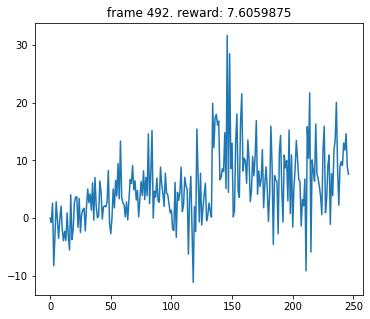

KeyboardInterrupt: 

In [10]:
early_stop = False
max_reward = 0
test_rewards = []
epoch  = 0

while epoch < num_epochs and not early_stop:

    log_probs = []
    values    = []
    states    = []
    actions   = []
    rewards   = []
    masks     = []

    state = env.reset(trader_happiness=(happiness_alpha**epoch)*happiness_beta, training=True,
                      batch_size=batch_size)

    for _ in range(run_lenght):
        # value, dist = model(state, np.reshape(state[:,-1,:],(batch_size, 1, num_inputs[1])))
        value, dist = model(state)

        action = dist.sample()
        next_state, reward, done, _, _ = env.step(action)

        log_prob = dist.log_prob(action)

        log_probs.append(log_prob)
        values.append(value)
        rewards.append(tf.expand_dims((reward,), axis=1))
        masks.append(tf.expand_dims((float(1 - done),), axis=1))

        states.append(state)
        actions.append(action)

        state = next_state

    # next_value, _ = model(next_state, np.reshape(next_state[:,-1,:],(batch_size, 1, num_inputs[1])))
    next_value, _ = model(next_state)
    returns = compute_gae(next_value, rewards, masks, values)

    returns_save = returns
    
    returns   = tf.reshape(tf.concat(returns, axis=1),(run_lenght*batch_size,1))
    log_probs = tf.concat(log_probs, axis=0)
    values    = tf.concat(values, axis=0)
    states    = tf.concat(states, axis=0)
    actions   = tf.concat(actions, axis=0)

    advantage = returns - values
    advantage = tf.reshape(advantage,(run_lenght*batch_size,1))

    ppo_update(ppo_epochs, batch_size, states, actions, log_probs, returns, advantage)

    if epoch % 2 == 0:
        for i in range(test_iterations):
            operation_array, days_array, total_reward = test_env(record_days=(i==test_iterations-1))
        test_rewards.append(mean_reward.result().numpy())
        with test_summary_writer.as_default():
            tf.summary.scalar('mean_test_reward', mean_reward.result(), step=epoch)
            tf.summary.scalar('last_test_reward', total_reward[0], step=epoch)
            tf.summary.image('Plot', plot(epoch, test_rewards), step=epoch)
        if (mean_reward.result() > max_reward):
            # serialize weights to HDF5
            if not os.path.exists(save_directory):
                os.makedirs(save_directory)
            pd.DataFrame(operation_array).to_csv(save_directory+"{}-operation-epoch{}.csv".format(identifier, epoch), 
                                                 header=env.get_current_symbols(), index=None)
            pd.DataFrame(days_array).to_csv(save_directory+"{}-endingday-epoch{}.csv".format(identifier, epoch), 
                                                 header=env.get_current_symbols(), index=None)
            if not os.path.exists(models_directory):
                os.makedirs(models_directory)
            model.save_weights(models_directory + "best-{}.h5".format(identifier))
            max_reward = mean_reward.result()
        if (mean_reward.result() > threshold_reward): early_stop = True
        mean_reward.reset_states()

    epoch += 1